In [1]:
import os
import random

import numpy as np
import pandas as pd

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Pytorch
import torch, torchvision, torch.utils
from torch import Tensor
from torch import cat
from torch.autograd.grad_mode import no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss, BCELoss, CrossEntropyLoss, MSELoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    Dropout
)

import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,RocCurveDisplay,classification_report,precision_score,recall_score,f1_score
import time
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import pickle
from IPython.display import display

In [3]:
def matrix_confusion(yt, yp,time_taken):
    data = {'Y_Real': yt,
            'Y_Pred': yp}

    df = pd.DataFrame(data, columns=['Y_Real','Y_Pred'])
    confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Pred'], rownames=['Real'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, fmt='g')

    plt.show()
    y_val = df['Y_Real'].to_numpy()
    predictions = df['Y_Pred'].to_numpy()
    accuracy = accuracy_score(y_val,predictions)
    precision = precision_score(y_val,predictions)
    recall = recall_score(y_val,predictions)
    f1 = f1_score(y_val,predictions)
    print('Time taken: ',time_taken)
    print('Test size:',len(y_val))
    print('Total Accuracy: ',accuracy)
    print('Total Precision: ',precision)
    print('Total Recall: ',recall)
    print('Total F1 Score: ',f1)
    print("Classification Report:\n")
    print(classification_report(y_val,predictions))


    return time_taken,accuracy,precision,recall,f1

In [4]:
torch.cuda.is_available()

True

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize your images as required
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

In [6]:
dataset = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/train', transform=transform)

In [7]:
def calculate_channel_stats(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    total_samples = 0
    mean = torch.zeros(3)  # Initialize mean for RGB channels
    std = torch.zeros(3)   # Initialize standard deviation for RGB channels
    
    for data, _ in loader:
        img = data.squeeze(0)  # Remove batch dimension (assuming batch_size=1)
        mean += torch.mean(img, dim=(1, 2))  # Compute mean along height and width dimensions
        std += torch.std(img, dim=(1, 2))    # Compute standard deviation along height and width dimensions
        total_samples += 1

    return mean / total_samples, std / total_samples

# Calculate mean and standard deviation for each channel
calculated_mean, calculated_std = calculate_channel_stats(dataset)
print("Calculated Mean for R, G, B channels:", calculated_mean)
print("Calculated Standard Deviation for R, G, B channels:", calculated_std)


Calculated Mean for R, G, B channels: tensor([0.4801, 0.4801, 0.4801])
Calculated Standard Deviation for R, G, B channels: tensor([0.2217, 0.2217, 0.2217])


In [8]:
transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(calculated_mean, calculated_std),
])

In [9]:
train_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/train', transform=transform)
test_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/test', transform=transform)
valid_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/valid', transform=transform)

In [10]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [11]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=8)
test_loader = DataLoader(valid_data, shuffle=True, batch_size=1)
hold_out_test_loader = DataLoader(test_data, shuffle=True, batch_size=1)

In [12]:
# Normal (0) and True, Pneumonia (1)
print((train_loader.dataset.class_to_idx))
print((test_loader.dataset.class_to_idx))
print((hold_out_test_loader.dataset.class_to_idx))

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


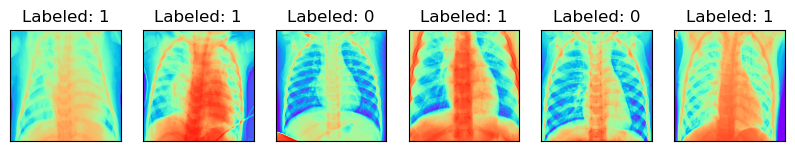

In [13]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap=plt.cm.rainbow)
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title(f"Labeled: {targets[0].item()}")

    n_samples_show -= 1

In [14]:
num_epochs_list = [4,8,16]
learning_rates = [0.0001,0.001, 0.01]
optimizers = ['SGD','Adam']

In [15]:
import warnings
warnings.filterwarnings("ignore")

Epochs: 4, learning rate: 0.0001, optimizer: SGD
Current: 1/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 72.921
Training [25%]	Loss: 0.5485	Accuracy: 72.92%
Saving model with test loss of 78.195
Training [50%]	Loss: 0.4616	Accuracy: 78.19%
Saving model with test loss of 82.144
Training [75%]	Loss: 0.4082	Accuracy: 82.14%
Saving model with test loss of 84.425
Training [100%]	Loss: 0.3720	Accuracy: 84.42%


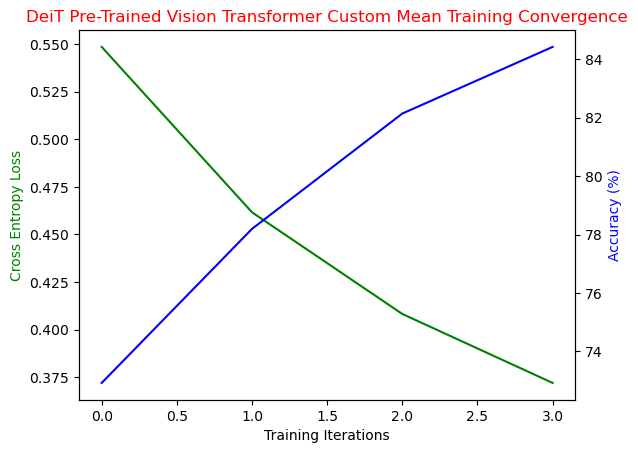

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.3479
	Accuracy: 87.30%
[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,

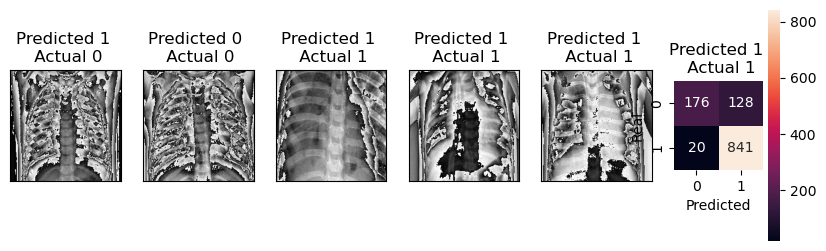

Time taken:  139.7282247543335
Test size: 1165
Total Accuracy:  0.8729613733905579
Total Precision:  0.8679050567595459
Total Recall:  0.9767711962833914
Total F1 Score:  0.9191256830601092
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.58      0.70       304
           1       0.87      0.98      0.92       861

    accuracy                           0.87      1165
   macro avg       0.88      0.78      0.81      1165
weighted avg       0.88      0.87      0.86      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs4_lr0.0001_optimizerSGD  139.728225  0.872961   

                                                    Precision    Recall  \
DieT ModelCustomMean_epochs4_lr0.0001_optimizerSGD   0.867905  0.976771   

                                                    F1 score  
DieT ModelCustomMean_epochs4_lr0.0001_optimizerSGD  0.919126

Data Stored Successfully
Epochs: 4, learning rate: 0.0001, optimizer: Adam
Current: 2/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 89.502
Training [25%]	Loss: 0.2577	Accuracy: 89.50%
Saving model with test loss of 92.715
Training [50%]	Loss: 0.1775	Accuracy: 92.72%
Saving model with test loss of 94.481
Training [75%]	Loss: 0.1574	Accuracy: 94.48%
Saving model with test loss of 94.530
Training [100%]	Loss: 0.1468	Accuracy: 94.53%


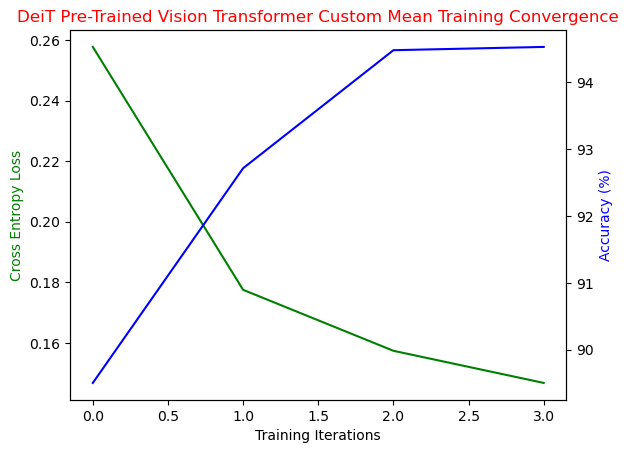

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1373
	Accuracy: 94.68%
[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,

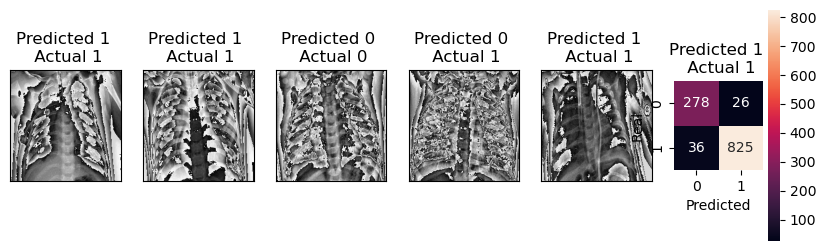

Time taken:  137.01672649383545
Test size: 1165
Total Accuracy:  0.9467811158798283
Total Precision:  0.9694477085781433
Total Recall:  0.9581881533101045
Total F1 Score:  0.9637850467289719
Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       304
           1       0.97      0.96      0.96       861

    accuracy                           0.95      1165
   macro avg       0.93      0.94      0.93      1165
weighted avg       0.95      0.95      0.95      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs4_lr0.0001_optimizer...  137.016726  0.946781   

                                                    Precision    Recall  \
DieT ModelCustomMean_epochs4_lr0.0001_optimizer...   0.969448  0.958188   

                                                    F1 score  
DieT ModelCustomMean_epochs4_lr0.0001_optimizer...  0.963785

Data Stored Successfully
Epochs: 4, learning rate: 0.001, optimizer: SGD
Current: 3/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 85.210
Training [25%]	Loss: 0.3454	Accuracy: 85.21%
Saving model with test loss of 90.091
Training [50%]	Loss: 0.2440	Accuracy: 90.09%
Saving model with test loss of 91.047
Training [75%]	Loss: 0.2205	Accuracy: 91.05%
Saving model with test loss of 92.004
Training [100%]	Loss: 0.2039	Accuracy: 92.00%


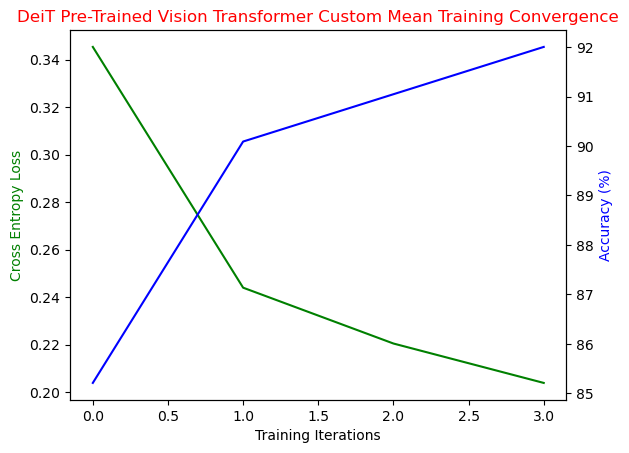

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1888
	Accuracy: 92.19%
[1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,

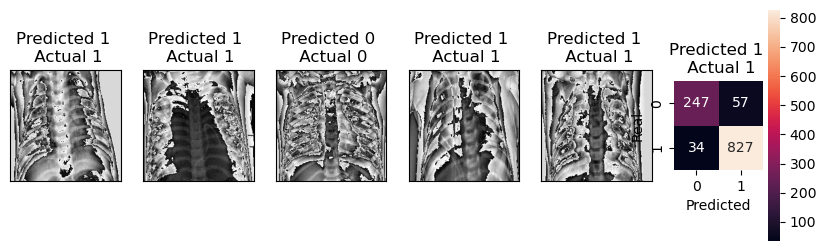

Time taken:  138.46724772453308
Test size: 1165
Total Accuracy:  0.9218884120171674
Total Precision:  0.9355203619909502
Total Recall:  0.9605110336817654
Total F1 Score:  0.9478510028653294
Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       304
           1       0.94      0.96      0.95       861

    accuracy                           0.92      1165
   macro avg       0.91      0.89      0.90      1165
weighted avg       0.92      0.92      0.92      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs4_lr0.001_optimizerSGD  138.467248  0.921888   

                                                   Precision    Recall  \
DieT ModelCustomMean_epochs4_lr0.001_optimizerSGD    0.93552  0.960511   

                                                   F1 score  
DieT ModelCustomMean_epochs4_lr0.001_optimizerSGD  0.947851

Data Stored Successfully
Epochs: 4, learning rate: 0.001, optimizer: Adam
Current: 4/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 91.047
Training [25%]	Loss: 0.2290	Accuracy: 91.05%
Saving model with test loss of 93.304
Training [50%]	Loss: 0.1763	Accuracy: 93.30%
Saving model with test loss of 94.187
Training [75%]	Loss: 0.1569	Accuracy: 94.19%
Saving model with test loss of 94.800
Training [100%]	Loss: 0.1402	Accuracy: 94.80%


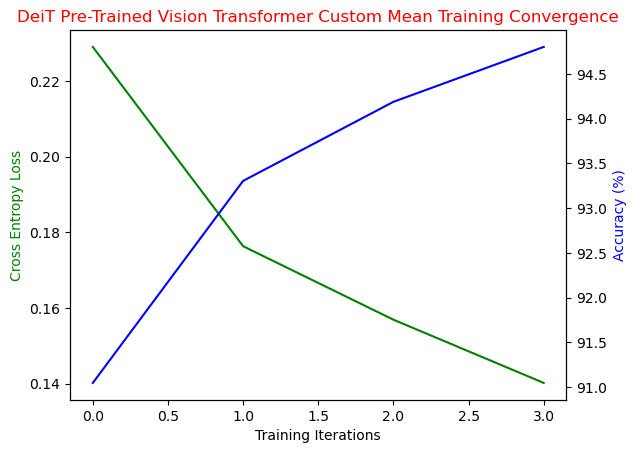

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1285
	Accuracy: 95.28%
[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,

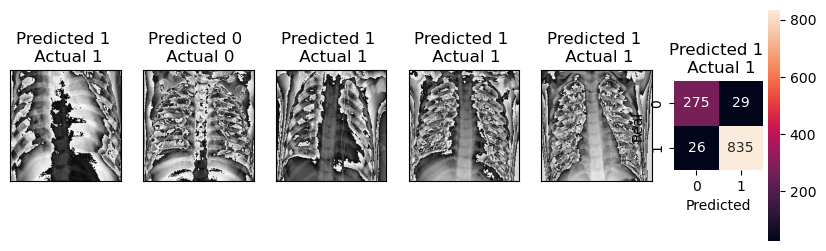

Time taken:  136.38377118110657
Test size: 1165
Total Accuracy:  0.9527896995708155
Total Precision:  0.9664351851851852
Total Recall:  0.9698025551684089
Total F1 Score:  0.9681159420289854
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       304
           1       0.97      0.97      0.97       861

    accuracy                           0.95      1165
   macro avg       0.94      0.94      0.94      1165
weighted avg       0.95      0.95      0.95      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs4_lr0.001_optimizerAdam  136.383771   0.95279   

                                                    Precision    Recall  \
DieT ModelCustomMean_epochs4_lr0.001_optimizerAdam   0.966435  0.969803   

                                                    F1 score  
DieT ModelCustomMean_epochs4_lr0.001_optimizerAdam  0.968116

Data Stored Successfully
Epochs: 4, learning rate: 0.01, optimizer: SGD
Current: 5/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 90.459
Training [25%]	Loss: 0.2362	Accuracy: 90.46%
Saving model with test loss of 93.230
Training [50%]	Loss: 0.1775	Accuracy: 93.23%
Saving model with test loss of 93.745
Training [75%]	Loss: 0.1587	Accuracy: 93.75%
Saving model with test loss of 94.260
Training [100%]	Loss: 0.1518	Accuracy: 94.26%


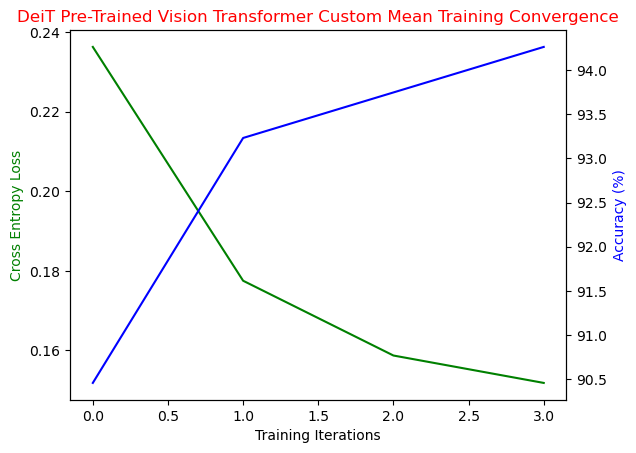

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1478
	Accuracy: 94.33%
[1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,

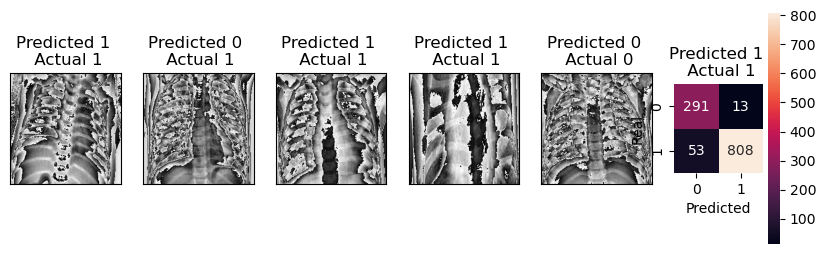

Time taken:  139.0782458782196
Test size: 1165
Total Accuracy:  0.9433476394849786
Total Precision:  0.9841656516443362
Total Recall:  0.9384436701509872
Total F1 Score:  0.9607609988109395
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       304
           1       0.98      0.94      0.96       861

    accuracy                           0.94      1165
   macro avg       0.92      0.95      0.93      1165
weighted avg       0.95      0.94      0.94      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs4_lr0.01_optimizerSGD  139.078246  0.943348   

                                                  Precision    Recall  \
DieT ModelCustomMean_epochs4_lr0.01_optimizerSGD   0.984166  0.938444   

                                                  F1 score  
DieT ModelCustomMean_epochs4_lr0.01_optimizerSGD  0.960761

Data Stored Successfully
Epochs: 4, learning rate: 0.01, optimizer: Adam
Current: 6/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 88.570
Training [25%]	Loss: 0.3393	Accuracy: 88.57%
Saving model with test loss of 91.121
Training [50%]	Loss: 0.2403	Accuracy: 91.12%
Saving model with test loss of 91.562
Training [75%]	Loss: 0.2256	Accuracy: 91.56%
Saving model with test loss of 90.900
Training [100%]	Loss: 0.2279	Accuracy: 90.90%


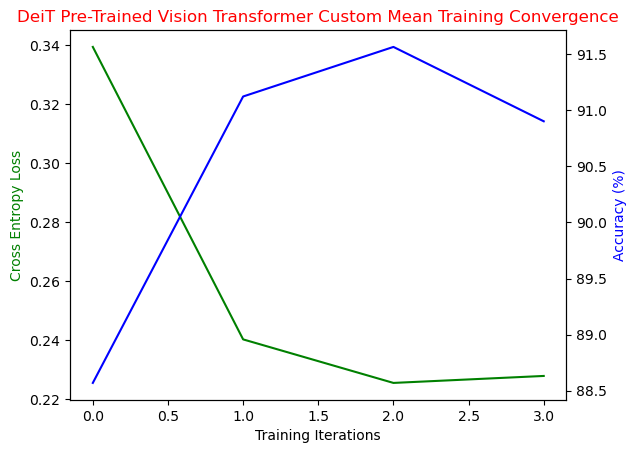

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1689
	Accuracy: 93.91%
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,

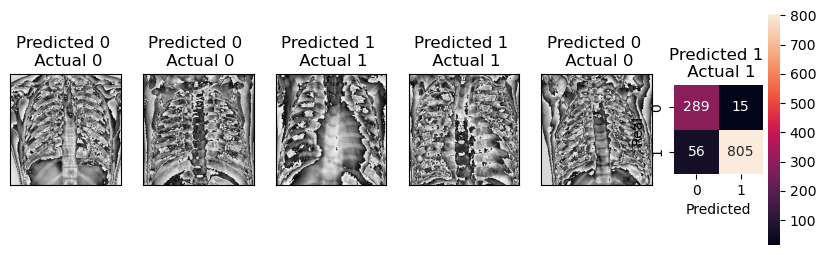

Time taken:  137.24786567687988
Test size: 1165
Total Accuracy:  0.9390557939914163
Total Precision:  0.9817073170731707
Total Recall:  0.9349593495934959
Total F1 Score:  0.9577632361689471
Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       304
           1       0.98      0.93      0.96       861

    accuracy                           0.94      1165
   macro avg       0.91      0.94      0.92      1165
weighted avg       0.94      0.94      0.94      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs4_lr0.01_optimizerAdam  137.247866  0.939056   

                                                   Precision    Recall  \
DieT ModelCustomMean_epochs4_lr0.01_optimizerAdam   0.981707  0.934959   

                                                   F1 score  
DieT ModelCustomMean_epochs4_lr0.01_optimizerAdam  0.957763

Data Stored Successfully
Epochs: 8, learning rate: 0.0001, optimizer: SGD
Current: 7/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 72.382
Training [12%]	Loss: 0.5497	Accuracy: 72.38%
Saving model with test loss of 78.980
Training [25%]	Loss: 0.4544	Accuracy: 78.98%
Saving model with test loss of 82.536
Training [38%]	Loss: 0.4009	Accuracy: 82.54%
Saving model with test loss of 85.259
Training [50%]	Loss: 0.3653	Accuracy: 85.26%
Saving model with test loss of 85.970
Training [62%]	Loss: 0.3382	Accuracy: 85.97%
Saving model with test loss of 87.491
Training [75%]	Loss: 0.3227	Accuracy: 87.49%
Saving model with test loss of 87.834
Training [88%]	Loss: 0.3026	Accuracy: 87.83%
Saving model with test loss of 88.055
Training [100%]	Loss: 0.2929	Accuracy: 88.05%


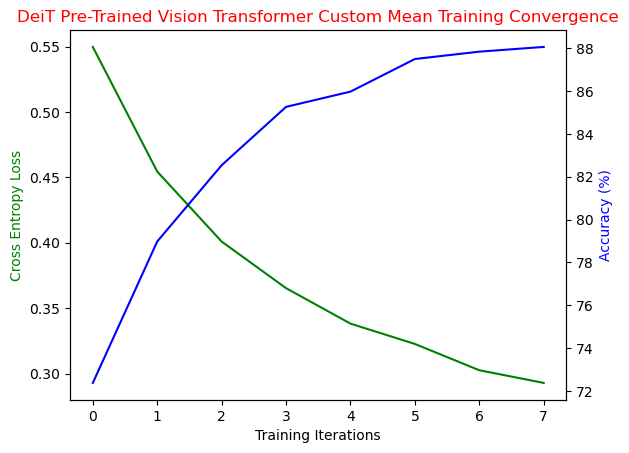

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.2760
	Accuracy: 89.36%
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,

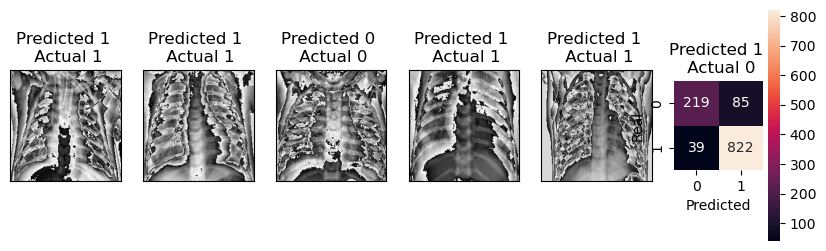

Time taken:  276.5328118801117
Test size: 1165
Total Accuracy:  0.8935622317596567
Total Precision:  0.906284454244763
Total Recall:  0.9547038327526133
Total F1 Score:  0.9298642533936651
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       304
           1       0.91      0.95      0.93       861

    accuracy                           0.89      1165
   macro avg       0.88      0.84      0.85      1165
weighted avg       0.89      0.89      0.89      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs8_lr0.0001_optimizerSGD  276.532812  0.893562   

                                                    Precision    Recall  \
DieT ModelCustomMean_epochs8_lr0.0001_optimizerSGD   0.906284  0.954704   

                                                    F1 score  
DieT ModelCustomMean_epochs8_lr0.0001_optimizerSGD  0.929864

Data Stored Successfully
Epochs: 8, learning rate: 0.0001, optimizer: Adam
Current: 8/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 89.232
Training [12%]	Loss: 0.2585	Accuracy: 89.23%
Saving model with test loss of 93.059
Training [25%]	Loss: 0.1784	Accuracy: 93.06%
Saving model with test loss of 94.015
Training [38%]	Loss: 0.1583	Accuracy: 94.02%
Saving model with test loss of 94.359
Training [50%]	Loss: 0.1486	Accuracy: 94.36%
Saving model with test loss of 94.776
Training [62%]	Loss: 0.1394	Accuracy: 94.78%
Saving model with test loss of 94.947
Training [75%]	Loss: 0.1332	Accuracy: 94.95%
Saving model with test loss of 95.438
Training [88%]	Loss: 0.1257	Accuracy: 95.44%
Saving model with test loss of 95.634
Training [100%]	Loss: 0.1226	Accuracy: 95.63%


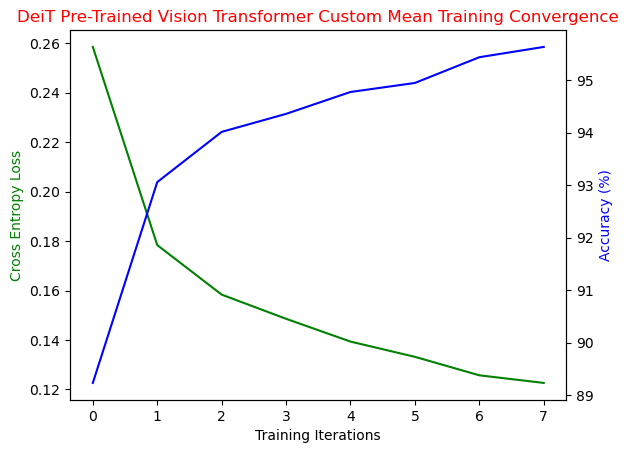

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1202
	Accuracy: 95.45%
[0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,

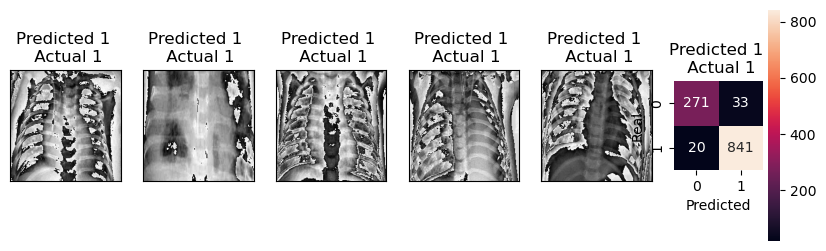

Time taken:  277.0642547607422
Test size: 1165
Total Accuracy:  0.9545064377682403
Total Precision:  0.9622425629290617
Total Recall:  0.9767711962833914
Total F1 Score:  0.9694524495677234
Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       304
           1       0.96      0.98      0.97       861

    accuracy                           0.95      1165
   macro avg       0.95      0.93      0.94      1165
weighted avg       0.95      0.95      0.95      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs8_lr0.0001_optimizer...  277.064255  0.954506   

                                                    Precision    Recall  \
DieT ModelCustomMean_epochs8_lr0.0001_optimizer...   0.962243  0.976771   

                                                    F1 score  
DieT ModelCustomMean_epochs8_lr0.0001_optimizer...  0.969452

Data Stored Successfully
Epochs: 8, learning rate: 0.001, optimizer: SGD
Current: 9/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 83.615
Training [12%]	Loss: 0.3702	Accuracy: 83.62%
Saving model with test loss of 90.434
Training [25%]	Loss: 0.2436	Accuracy: 90.43%
Saving model with test loss of 92.004
Training [38%]	Loss: 0.2138	Accuracy: 92.00%
Saving model with test loss of 92.053
Training [50%]	Loss: 0.2062	Accuracy: 92.05%
Saving model with test loss of 92.200
Training [62%]	Loss: 0.1928	Accuracy: 92.20%
Saving model with test loss of 92.887
Training [75%]	Loss: 0.1822	Accuracy: 92.89%
Saving model with test loss of 93.108
Training [88%]	Loss: 0.1781	Accuracy: 93.11%
Saving model with test loss of 93.132
Training [100%]	Loss: 0.1760	Accuracy: 93.13%


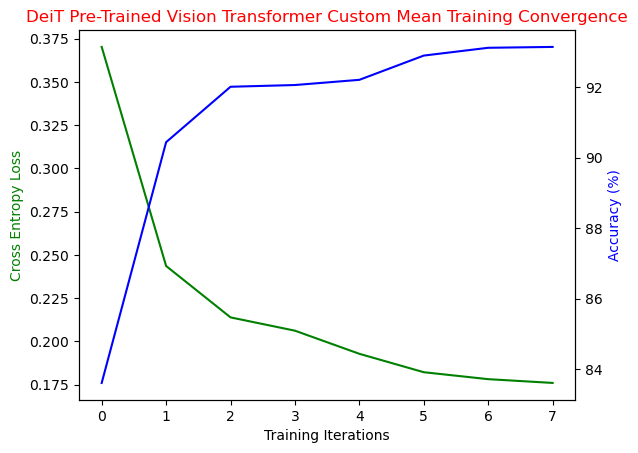

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1600
	Accuracy: 93.65%
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,

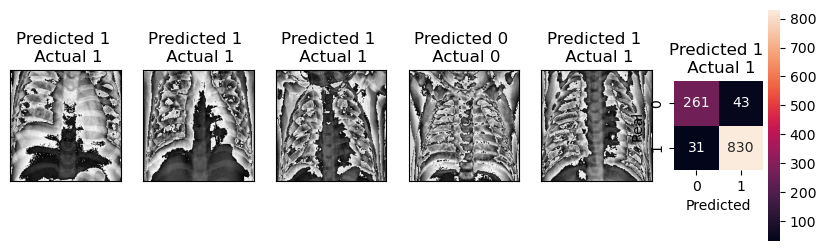

Time taken:  274.4131693840027
Test size: 1165
Total Accuracy:  0.936480686695279
Total Precision:  0.9507445589919816
Total Recall:  0.9639953542392566
Total F1 Score:  0.9573241061130334
Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.86      0.88       304
           1       0.95      0.96      0.96       861

    accuracy                           0.94      1165
   macro avg       0.92      0.91      0.92      1165
weighted avg       0.94      0.94      0.94      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs8_lr0.001_optimizerSGD  274.413169  0.936481   

                                                   Precision    Recall  \
DieT ModelCustomMean_epochs8_lr0.001_optimizerSGD   0.950745  0.963995   

                                                   F1 score  
DieT ModelCustomMean_epochs8_lr0.001_optimizerSGD  0.957324

Data Stored Successfully
Epochs: 8, learning rate: 0.001, optimizer: Adam
Current: 10/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 91.562
Training [12%]	Loss: 0.2207	Accuracy: 91.56%
Saving model with test loss of 93.745
Training [25%]	Loss: 0.1668	Accuracy: 93.75%
Saving model with test loss of 94.260
Training [38%]	Loss: 0.1511	Accuracy: 94.26%
Saving model with test loss of 94.432
Training [50%]	Loss: 0.1488	Accuracy: 94.43%
Saving model with test loss of 94.653
Training [62%]	Loss: 0.1399	Accuracy: 94.65%
Saving model with test loss of 95.242
Training [75%]	Loss: 0.1320	Accuracy: 95.24%
Saving model with test loss of 95.266
Training [88%]	Loss: 0.1275	Accuracy: 95.27%
Saving model with test loss of 95.487
Training [100%]	Loss: 0.1221	Accuracy: 95.49%


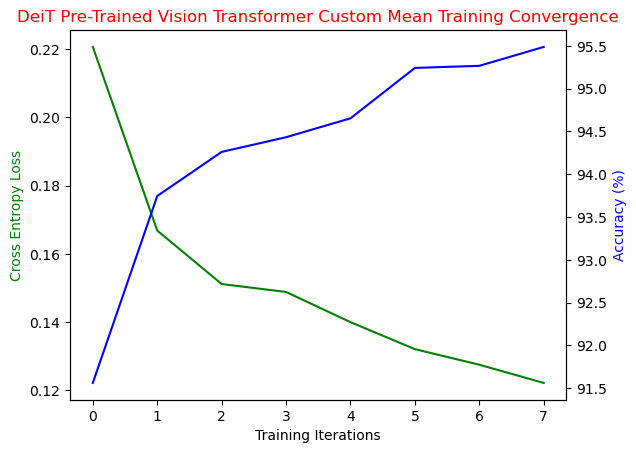

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1200
	Accuracy: 95.88%
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,

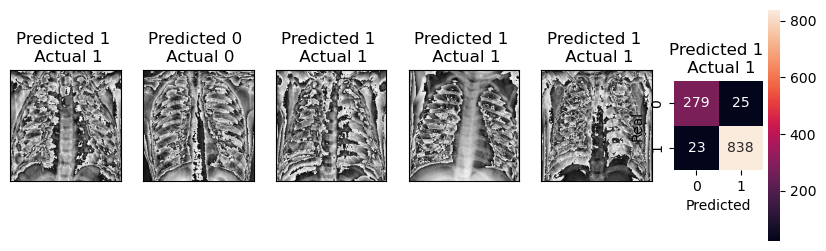

Time taken:  275.8309631347656
Test size: 1165
Total Accuracy:  0.9587982832618026
Total Precision:  0.9710312862108922
Total Recall:  0.9732868757259001
Total F1 Score:  0.9721577726218096
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       304
           1       0.97      0.97      0.97       861

    accuracy                           0.96      1165
   macro avg       0.95      0.95      0.95      1165
weighted avg       0.96      0.96      0.96      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs8_lr0.001_optimizerAdam  275.830963  0.958798   

                                                    Precision    Recall  \
DieT ModelCustomMean_epochs8_lr0.001_optimizerAdam   0.971031  0.973287   

                                                    F1 score  
DieT ModelCustomMean_epochs8_lr0.001_optimizerAdam  0.972158

Data Stored Successfully
Epochs: 8, learning rate: 0.01, optimizer: SGD
Current: 11/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 90.410
Training [12%]	Loss: 0.2399	Accuracy: 90.41%
Saving model with test loss of 93.255
Training [25%]	Loss: 0.1736	Accuracy: 93.25%
Saving model with test loss of 93.696
Training [38%]	Loss: 0.1587	Accuracy: 93.70%
Saving model with test loss of 94.555
Training [50%]	Loss: 0.1491	Accuracy: 94.55%
Saving model with test loss of 94.947
Training [62%]	Loss: 0.1384	Accuracy: 94.95%
Saving model with test loss of 94.898
Training [75%]	Loss: 0.1358	Accuracy: 94.90%
Saving model with test loss of 95.143
Training [88%]	Loss: 0.1294	Accuracy: 95.14%
Saving model with test loss of 95.462
Training [100%]	Loss: 0.1222	Accuracy: 95.46%


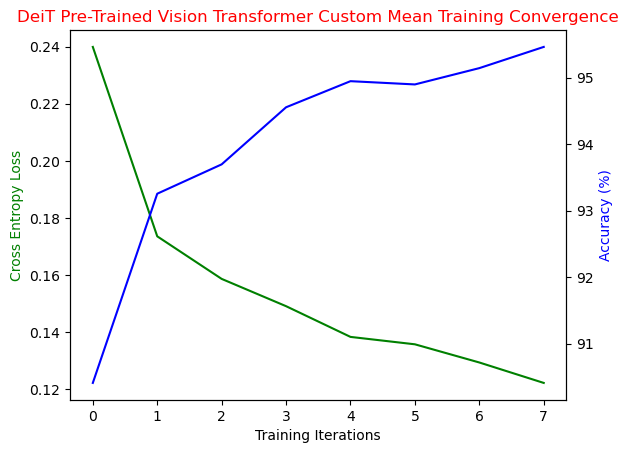

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1205
	Accuracy: 95.11%
[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,

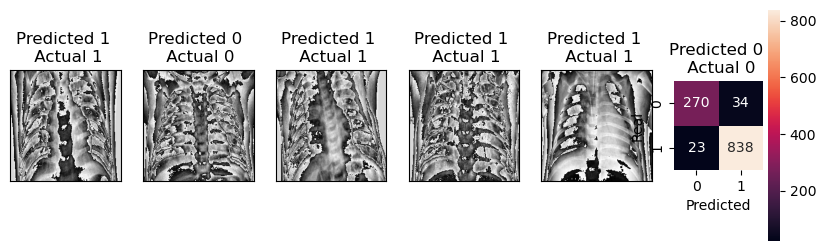

Time taken:  274.7266345024109
Test size: 1165
Total Accuracy:  0.9510729613733906
Total Precision:  0.9610091743119266
Total Recall:  0.9732868757259001
Total F1 Score:  0.9671090594345066
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       304
           1       0.96      0.97      0.97       861

    accuracy                           0.95      1165
   macro avg       0.94      0.93      0.94      1165
weighted avg       0.95      0.95      0.95      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs8_lr0.01_optimizerSGD  274.726635  0.951073   

                                                  Precision    Recall  \
DieT ModelCustomMean_epochs8_lr0.01_optimizerSGD   0.961009  0.973287   

                                                  F1 score  
DieT ModelCustomMean_epochs8_lr0.01_optimizerSGD  0.967109

Data Stored Successfully
Epochs: 8, learning rate: 0.01, optimizer: Adam
Current: 12/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 88.570
Training [12%]	Loss: 0.3175	Accuracy: 88.57%
Saving model with test loss of 90.704
Training [25%]	Loss: 0.2493	Accuracy: 90.70%
Saving model with test loss of 91.464
Training [38%]	Loss: 0.2229	Accuracy: 91.46%
Saving model with test loss of 90.483
Training [50%]	Loss: 0.2292	Accuracy: 90.48%
Saving model with test loss of 91.979
Training [62%]	Loss: 0.2086	Accuracy: 91.98%
Saving model with test loss of 91.832
Training [75%]	Loss: 0.2115	Accuracy: 91.83%
Saving model with test loss of 92.421
Training [88%]	Loss: 0.1898	Accuracy: 92.42%
Saving model with test loss of 91.930
Training [100%]	Loss: 0.2014	Accuracy: 91.93%


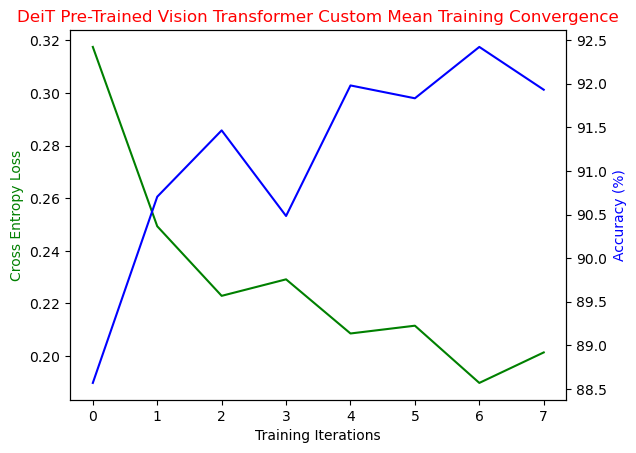

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1630
	Accuracy: 94.16%
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,

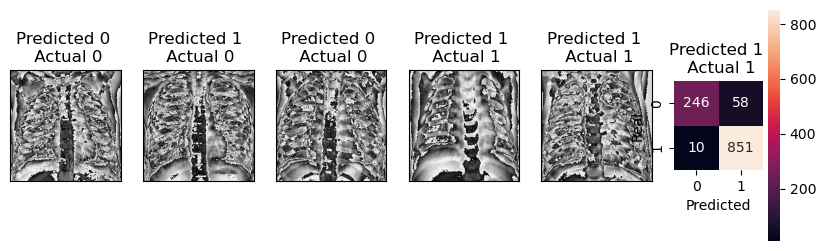

Time taken:  274.71758365631104
Test size: 1165
Total Accuracy:  0.9416309012875537
Total Precision:  0.9361936193619362
Total Recall:  0.9883855981416957
Total F1 Score:  0.9615819209039547
Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.81      0.88       304
           1       0.94      0.99      0.96       861

    accuracy                           0.94      1165
   macro avg       0.95      0.90      0.92      1165
weighted avg       0.94      0.94      0.94      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs8_lr0.01_optimizerAdam  274.717584  0.941631   

                                                   Precision    Recall  \
DieT ModelCustomMean_epochs8_lr0.01_optimizerAdam   0.936194  0.988386   

                                                   F1 score  
DieT ModelCustomMean_epochs8_lr0.01_optimizerAdam  0.961582

Data Stored Successfully
Epochs: 16, learning rate: 0.0001, optimizer: SGD
Current: 13/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Training [6%]	Loss: 0.5458	Accuracy: 72.48%
Saving model with test loss of 78.857
Training [12%]	Loss: 0.4474	Accuracy: 78.86%
Training [19%]	Loss: 0.3975	Accuracy: 83.12%
Saving model with test loss of 85.725
Training [25%]	Loss: 0.3648	Accuracy: 85.72%
Saving model with test loss of 86.632
Training [31%]	Loss: 0.3399	Accuracy: 86.63%
Training [38%]	Loss: 0.3181	Accuracy: 87.86%
Saving model with test loss of 88.079
Training [44%]	Loss: 0.3052	Accuracy: 88.08%
Saving model with test loss of 88.815
Training [50%]	Loss: 0.2919	Accuracy: 88.82%
Training [56%]	Loss: 0.2844	Accuracy: 89.18%
Saving model with test loss of 89.551
Training [62%]	Loss: 0.2738	Accuracy: 89.55%
Training [69%]	Loss: 0.2682	Accuracy: 89.85%
Saving model with test loss of 90.017
Training [75%]	Loss: 0.2598	Accuracy: 90.02%
Saving model with test loss of 89.919
Training [81%]	Loss: 0.2598	Accuracy: 89.92%
Training [88%]	Loss: 0.2525	Accuracy: 90.46%
Saving model with test loss of 90.508
Training [94%]	Loss: 0.2461	A

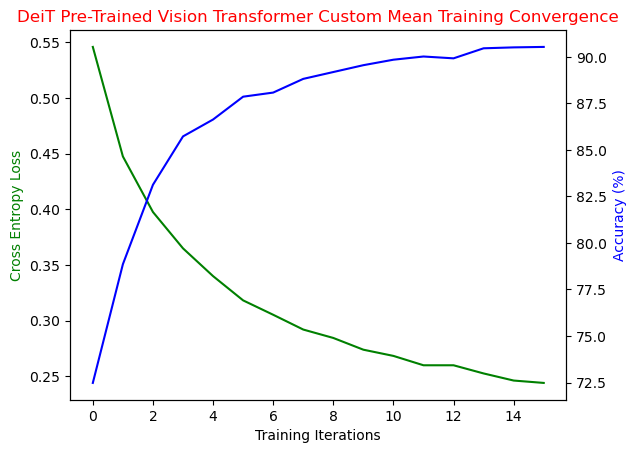

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.2299
	Accuracy: 90.82%
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

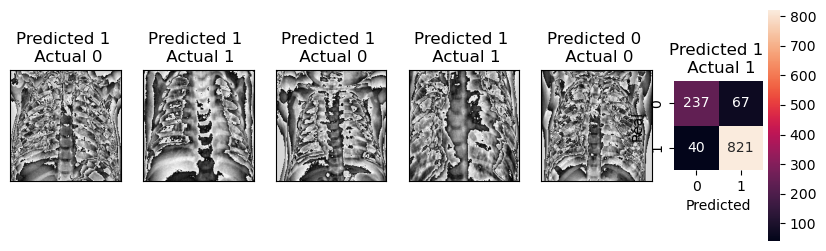

Time taken:  550.0472476482391
Test size: 1165
Total Accuracy:  0.9081545064377683
Total Precision:  0.9245495495495496
Total Recall:  0.9535423925667829
Total F1 Score:  0.938822184105203
Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       304
           1       0.92      0.95      0.94       861

    accuracy                           0.91      1165
   macro avg       0.89      0.87      0.88      1165
weighted avg       0.91      0.91      0.91      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs16_lr0.0001_optimize...  550.047248  0.908155   

                                                    Precision    Recall  \
DieT ModelCustomMean_epochs16_lr0.0001_optimize...    0.92455  0.953542   

                                                    F1 score  
DieT ModelCustomMean_epochs16_lr0.0001_optimize...  0.938822

Data Stored Successfully
Epochs: 16, learning rate: 0.0001, optimizer: Adam
Current: 14/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Training [6%]	Loss: 0.2631	Accuracy: 88.94%
Saving model with test loss of 93.108
Training [12%]	Loss: 0.1777	Accuracy: 93.11%
Training [19%]	Loss: 0.1599	Accuracy: 93.84%
Saving model with test loss of 94.849
Training [25%]	Loss: 0.1466	Accuracy: 94.85%
Saving model with test loss of 94.874
Training [31%]	Loss: 0.1405	Accuracy: 94.87%
Training [38%]	Loss: 0.1317	Accuracy: 95.22%
Saving model with test loss of 95.315
Training [44%]	Loss: 0.1267	Accuracy: 95.32%
Saving model with test loss of 95.781
Training [50%]	Loss: 0.1245	Accuracy: 95.78%
Training [56%]	Loss: 0.1152	Accuracy: 95.95%
Saving model with test loss of 95.830
Training [62%]	Loss: 0.1120	Accuracy: 95.83%
Training [69%]	Loss: 0.1089	Accuracy: 95.88%
Saving model with test loss of 96.002
Training [75%]	Loss: 0.1061	Accuracy: 96.00%
Saving model with test loss of 96.591
Training [81%]	Loss: 0.0990	Accuracy: 96.59%
Training [88%]	Loss: 0.0995	Accuracy: 96.42%
Saving model with test loss of 96.640
Training [94%]	Loss: 0.0919	A

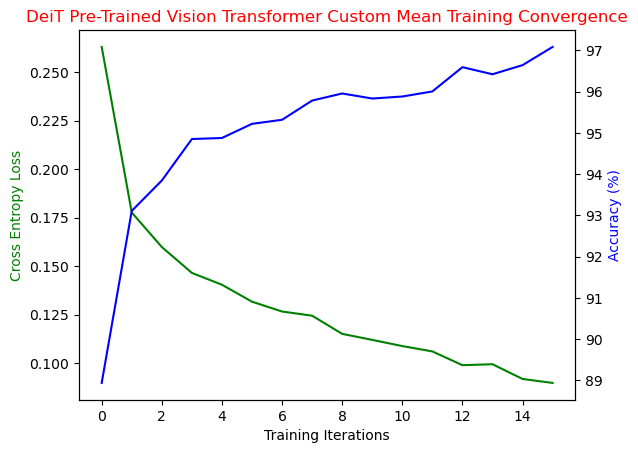

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1085
	Accuracy: 96.05%
[1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,

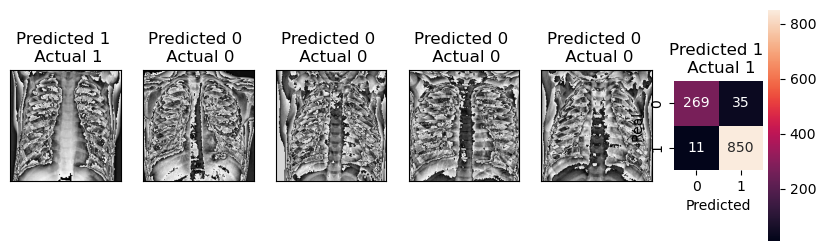

Time taken:  552.4156820774078
Test size: 1165
Total Accuracy:  0.9605150214592275
Total Precision:  0.96045197740113
Total Recall:  0.9872241579558653
Total F1 Score:  0.9736540664375715
Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       304
           1       0.96      0.99      0.97       861

    accuracy                           0.96      1165
   macro avg       0.96      0.94      0.95      1165
weighted avg       0.96      0.96      0.96      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs16_lr0.0001_optimize...  552.415682  0.960515   

                                                    Precision    Recall  \
DieT ModelCustomMean_epochs16_lr0.0001_optimize...   0.960452  0.987224   

                                                    F1 score  
DieT ModelCustomMean_epochs16_lr0.0001_optimize...  0.973654

Data Stored Successfully
Epochs: 16, learning rate: 0.001, optimizer: SGD
Current: 15/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Training [6%]	Loss: 0.3680	Accuracy: 84.11%
Saving model with test loss of 89.796
Training [12%]	Loss: 0.2501	Accuracy: 89.80%
Training [19%]	Loss: 0.2225	Accuracy: 91.17%
Saving model with test loss of 91.759
Training [25%]	Loss: 0.2056	Accuracy: 91.76%
Saving model with test loss of 92.102
Training [31%]	Loss: 0.1926	Accuracy: 92.10%
Training [38%]	Loss: 0.1833	Accuracy: 92.91%
Saving model with test loss of 93.427
Training [44%]	Loss: 0.1812	Accuracy: 93.43%
Saving model with test loss of 93.451
Training [50%]	Loss: 0.1769	Accuracy: 93.45%
Training [56%]	Loss: 0.1715	Accuracy: 93.45%
Saving model with test loss of 93.377
Training [62%]	Loss: 0.1703	Accuracy: 93.38%
Training [69%]	Loss: 0.1631	Accuracy: 93.92%
Saving model with test loss of 93.623
Training [75%]	Loss: 0.1650	Accuracy: 93.62%
Saving model with test loss of 94.015
Training [81%]	Loss: 0.1593	Accuracy: 94.02%
Training [88%]	Loss: 0.1579	Accuracy: 93.94%
Saving model with test loss of 94.481
Training [94%]	Loss: 0.1515	A

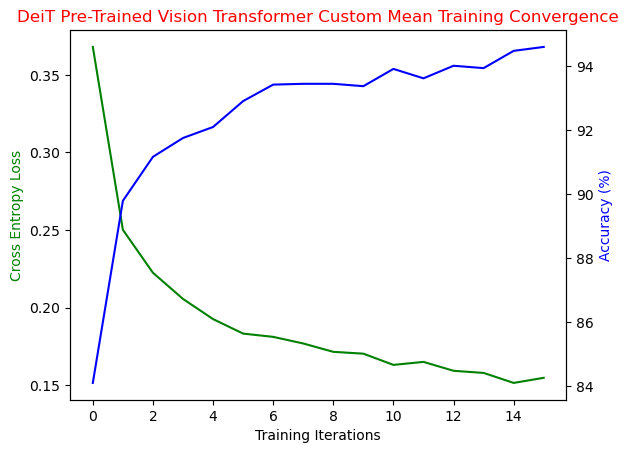

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1410
	Accuracy: 94.42%
[0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,

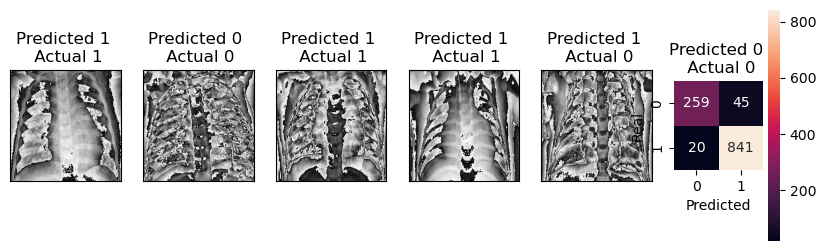

Time taken:  553.8011994361877
Test size: 1165
Total Accuracy:  0.944206008583691
Total Precision:  0.9492099322799097
Total Recall:  0.9767711962833914
Total F1 Score:  0.9627933600457927
Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       304
           1       0.95      0.98      0.96       861

    accuracy                           0.94      1165
   macro avg       0.94      0.91      0.93      1165
weighted avg       0.94      0.94      0.94      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs16_lr0.001_optimizerSGD  553.801199  0.944206   

                                                    Precision    Recall  \
DieT ModelCustomMean_epochs16_lr0.001_optimizerSGD    0.94921  0.976771   

                                                    F1 score  
DieT ModelCustomMean_epochs16_lr0.001_optimizerSGD  0.962793

Data Stored Successfully
Epochs: 16, learning rate: 0.001, optimizer: Adam
Current: 16/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Training [6%]	Loss: 0.2288	Accuracy: 91.02%
Saving model with test loss of 93.745
Training [12%]	Loss: 0.1716	Accuracy: 93.75%
Training [19%]	Loss: 0.1555	Accuracy: 94.41%
Saving model with test loss of 94.359
Training [25%]	Loss: 0.1528	Accuracy: 94.36%
Saving model with test loss of 95.094
Training [31%]	Loss: 0.1371	Accuracy: 95.09%
Training [38%]	Loss: 0.1307	Accuracy: 94.92%
Saving model with test loss of 95.315
Training [44%]	Loss: 0.1224	Accuracy: 95.32%
Saving model with test loss of 95.536
Training [50%]	Loss: 0.1214	Accuracy: 95.54%
Training [56%]	Loss: 0.1183	Accuracy: 95.46%
Saving model with test loss of 95.217
Training [62%]	Loss: 0.1138	Accuracy: 95.22%
Training [69%]	Loss: 0.1124	Accuracy: 95.36%
Saving model with test loss of 96.051
Training [75%]	Loss: 0.1011	Accuracy: 96.05%
Saving model with test loss of 96.002
Training [81%]	Loss: 0.1060	Accuracy: 96.00%
Training [88%]	Loss: 0.0978	Accuracy: 96.32%
Saving model with test loss of 96.493
Training [94%]	Loss: 0.0936	A

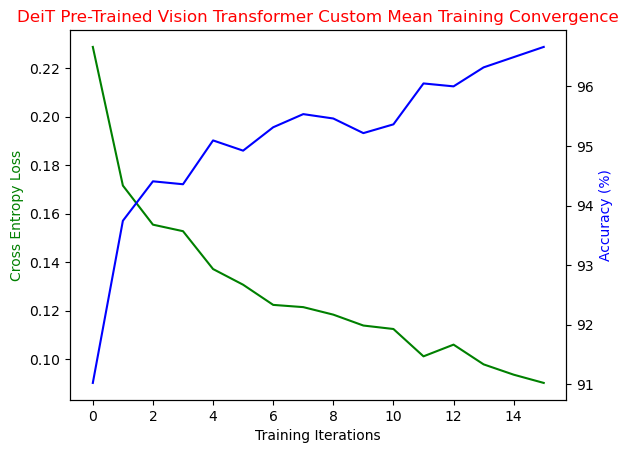

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1120
	Accuracy: 96.22%
[0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,

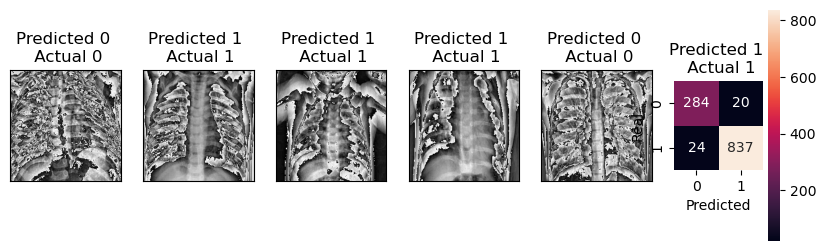

Time taken:  551.6250305175781
Test size: 1165
Total Accuracy:  0.9622317596566523
Total Precision:  0.9766627771295215
Total Recall:  0.9721254355400697
Total F1 Score:  0.9743888242142025
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       304
           1       0.98      0.97      0.97       861

    accuracy                           0.96      1165
   macro avg       0.95      0.95      0.95      1165
weighted avg       0.96      0.96      0.96      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs16_lr0.001_optimizer...  551.625031  0.962232   

                                                    Precision    Recall  \
DieT ModelCustomMean_epochs16_lr0.001_optimizer...   0.976663  0.972125   

                                                    F1 score  
DieT ModelCustomMean_epochs16_lr0.001_optimizer...  0.974389

Data Stored Successfully
Epochs: 16, learning rate: 0.01, optimizer: SGD
Current: 17/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Training [6%]	Loss: 0.2458	Accuracy: 89.75%
Saving model with test loss of 93.255
Training [12%]	Loss: 0.1733	Accuracy: 93.25%
Training [19%]	Loss: 0.1603	Accuracy: 93.92%
Saving model with test loss of 94.236
Training [25%]	Loss: 0.1499	Accuracy: 94.24%
Saving model with test loss of 94.972
Training [31%]	Loss: 0.1436	Accuracy: 94.97%
Training [38%]	Loss: 0.1343	Accuracy: 95.22%
Saving model with test loss of 95.364
Training [44%]	Loss: 0.1314	Accuracy: 95.36%
Saving model with test loss of 95.217
Training [50%]	Loss: 0.1200	Accuracy: 95.22%
Training [56%]	Loss: 0.1179	Accuracy: 95.71%
Saving model with test loss of 95.659
Training [62%]	Loss: 0.1155	Accuracy: 95.66%
Training [69%]	Loss: 0.1121	Accuracy: 95.81%
Saving model with test loss of 95.413
Training [75%]	Loss: 0.1120	Accuracy: 95.41%
Saving model with test loss of 96.223
Training [81%]	Loss: 0.1044	Accuracy: 96.22%
Training [88%]	Loss: 0.1030	Accuracy: 95.98%
Saving model with test loss of 96.640
Training [94%]	Loss: 0.0960	A

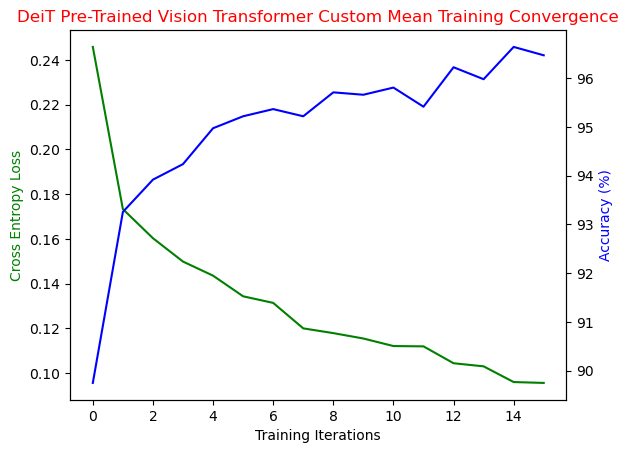

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1083
	Accuracy: 96.31%
[1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,

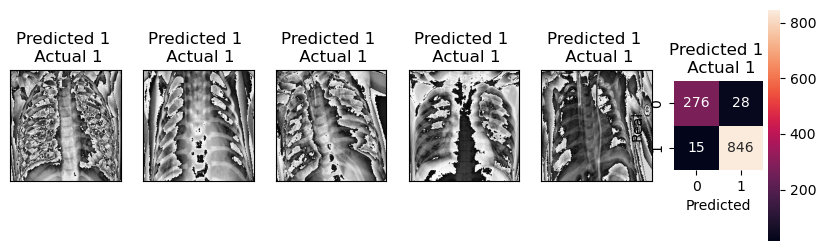

Time taken:  548.3657248020172
Test size: 1165
Total Accuracy:  0.9630901287553648
Total Precision:  0.9679633867276888
Total Recall:  0.9825783972125436
Total F1 Score:  0.9752161383285303
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       304
           1       0.97      0.98      0.98       861

    accuracy                           0.96      1165
   macro avg       0.96      0.95      0.95      1165
weighted avg       0.96      0.96      0.96      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs16_lr0.01_optimizerSGD  548.365725   0.96309   

                                                   Precision    Recall  \
DieT ModelCustomMean_epochs16_lr0.01_optimizerSGD   0.967963  0.982578   

                                                   F1 score  
DieT ModelCustomMean_epochs16_lr0.01_optimizerSGD  0.975216

Data Stored Successfully
Epochs: 16, learning rate: 0.01, optimizer: Adam
Current: 18/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Training [6%]	Loss: 0.3049	Accuracy: 89.60%
Saving model with test loss of 90.827
Training [12%]	Loss: 0.2479	Accuracy: 90.83%
Training [19%]	Loss: 0.2303	Accuracy: 91.66%
Saving model with test loss of 90.974
Training [25%]	Loss: 0.2269	Accuracy: 90.97%
Saving model with test loss of 89.845
Training [31%]	Loss: 0.2264	Accuracy: 89.85%
Training [38%]	Loss: 0.2377	Accuracy: 91.22%
Saving model with test loss of 91.881
Training [44%]	Loss: 0.2183	Accuracy: 91.88%
Saving model with test loss of 91.464
Training [50%]	Loss: 0.2104	Accuracy: 91.46%
Training [56%]	Loss: 0.2174	Accuracy: 91.61%
Saving model with test loss of 91.661
Training [62%]	Loss: 0.2044	Accuracy: 91.66%
Training [69%]	Loss: 0.2202	Accuracy: 91.44%
Saving model with test loss of 92.887
Training [75%]	Loss: 0.1800	Accuracy: 92.89%
Saving model with test loss of 92.617
Training [81%]	Loss: 0.1928	Accuracy: 92.62%
Training [88%]	Loss: 0.1888	Accuracy: 92.49%
Saving model with test loss of 92.421
Training [94%]	Loss: 0.1869	A

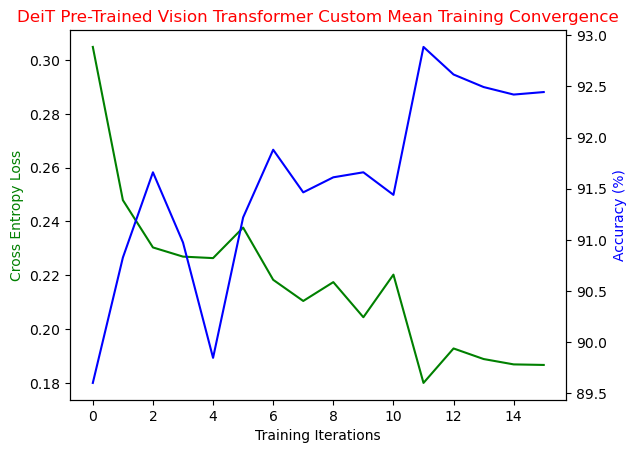

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1662
	Accuracy: 93.99%
[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,

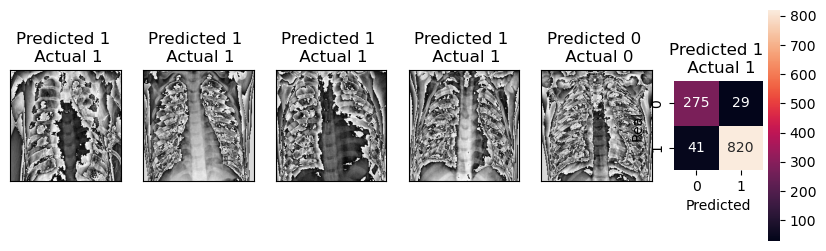

Time taken:  552.3793964385986
Test size: 1165
Total Accuracy:  0.9399141630901288
Total Precision:  0.9658421672555948
Total Recall:  0.9523809523809523
Total F1 Score:  0.9590643274853802
Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       304
           1       0.97      0.95      0.96       861

    accuracy                           0.94      1165
   macro avg       0.92      0.93      0.92      1165
weighted avg       0.94      0.94      0.94      1165



Time  Accuracy  \
DieT ModelCustomMean_epochs16_lr0.01_optimizerAdam  552.379396  0.939914   

                                                    Precision    Recall  \
DieT ModelCustomMean_epochs16_lr0.01_optimizerAdam   0.965842  0.952381   

                                                    F1 score  
DieT ModelCustomMean_epochs16_lr0.01_optimizerAdam  0.959064

Data Stored Successfully


In [16]:
number_done = 0
for epochs in num_epochs_list:
    for learning_rate in learning_rates:
        for optimizer_name in optimizers:
            print(f"Epochs: {epochs}, learning rate: {learning_rate}, optimizer: {optimizer_name}")
            number_done+=1
            print(f"Current: {number_done}/18")
            model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
            for param in model.parameters(): #freeze model
                param.requires_grad = False

            n_inputs = model.head.in_features
            model.head = Sequential(
                Linear(n_inputs, 512),
                ReLU(),
                Dropout(0.3),
                Linear(512, 2) # 2 classes
            )
            model = model.to('cuda')
            if optimizer_name == 'SGD':
                    optimizer = optim.SGD(model.parameters(),lr=learning_rate)
            else:
                optimizer = optim.Adam(model.parameters(),lr=learning_rate)
            
            loss_func = CrossEntropyLoss().to('cuda')
            model.train()
            count = 1
            loss_list = []
            total_accuracy = []
            model_path2 = f"C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/DeitTune/DeiT modelCustomMean_epochs{epochs}_lr{learning_rate}_optimizer{optimizer_name}.pt"
            tic = time.time()
            for epoch in range(epochs):
                correct = 0
                total_loss = []
                batch_size = 0
                for batch_idx, (data, target) in enumerate(train_loader):
                    batch_size+=1
                    optimizer.zero_grad(set_to_none=True)
                    output = model(data.to('cuda'))  # Forward pass, Data to GPU
                    loss = loss_func(output, target.to('cuda')) #Labels to GPU
                    loss.backward()  # Backward pass
                    optimizer.step()
                    total_loss.append(loss.item())
                    train_pred = output.argmax(dim=1, keepdim=True)
                    correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
                loss_list.append(sum(total_loss) / len(total_loss))
                accuracy = 100 * correct / 4077 # No. of training examples = 4077
                total_accuracy.append(accuracy)
                if ((100*(epoch+1))//epochs)//(count*10) >0 :
                    count+=1
                    print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
                    torch.save(model.state_dict(), model_path2)
                print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")


            toc = time.time()
            fig, ax1 = plt.subplots()
            ax1.plot(loss_list, 'g-')
            ax2 = ax1.twinx()
            ax2.plot(total_accuracy, 'b')
            plt.title("DeiT Pre-Trained Vision Transformer Custom Mean Training Convergence", color='red')
            ax1.set_xlabel("Training Iterations")
            ax1.set_ylabel("Cross Entropy Loss", color='g')
            ax2.set_ylabel("Accuracy (%)", color='b')
            plt.show()
            torch.save(model.state_dict(), model_path2)
            model_temp = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
            model_temp.head = Sequential(
                Linear(n_inputs, 512),
                ReLU(),
                Dropout(0.3),
                Linear(512, 2) # 2 classes
            )
            model_temp.load_state_dict(torch.load(model_path2))
            model_temp= model_temp.to('cuda')
            batch_size=1

            model_temp.eval()
            pred_targets = []
            test_targets= []
            with no_grad():

                correct = 0
                for batch_idx, (data, target) in enumerate(test_loader):
                    output = model_temp(data.to('cuda'))
                    if len(output.shape) == 1:
                        output = output.reshape(1, *output.shape)
                    pred = output.argmax(dim=1, keepdim=True)
                    pred_targets.append(pred.item())
                    test_targets.append(target.item())
                    correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

                    loss = loss_func(output, target.to('cuda'))
                    total_loss.append(loss.item())

                print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
                print(test_targets)
                print(pred_targets)
            from PIL import Image
            #abc
            n_samples_show = 6
            count = 0
            fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

            model_temp.eval()
            with no_grad():
                for batch_idx, (data, target) in enumerate(test_loader):
                    if count == n_samples_show:
                        break
                    output = model_temp(data.to('cuda')[0:1])
                    if len(output.shape) == 1:
                        output = output.reshape(3, *output.shape)

                    pred = output.argmax(dim=1, keepdim=True)
                    test_targets2 = target.item()
                    axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

                    axes[count].set_xticks([])
                    axes[count].set_yticks([])
                    axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

                    count += 1
            time_taken = toc-tic
            val_diet = matrix_confusion(test_targets, pred_targets,time_taken)
            name_diet = f"DieT ModelCustomMean_epochs{epochs}_lr{learning_rate}_optimizer{optimizer_name}"
            outdiet = pd.DataFrame([val_diet],
                            index = [name_diet],
                            columns=['Time','Accuracy','Precision','Recall','F1 score'])
            outdiet.sort_values('Time')
            display(outdiet)
            filepath1 = f"C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/DeitTune/outputdietmodelCustomMean_epochs{epochs}_lr{learning_rate}_optimizer{optimizer_name}.pickle"
            with open(filepath1, 'wb') as file:
                # Serialize and write the variable to the file
                pickle.dump(outdiet, file)
                print("Data Stored Successfully")